<a href="https://colab.research.google.com/github/hylinux1024/ml-class/blob/main/Final_Projcet_Generate_Images_Using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Projcet: Generate Images Using DCGAN



This task is demonstrating to generate images using DCGAN which original paper is https://arxiv.org/pdf/1511.06434.pdf.  

We use the dataset is fashion mnist which similar to mnist dataset, instead of images of the digits 0 to 9, fashion mnist contains 10 different types of clothing.  
There are several step of this article:  
1. Preparing
2. Build the model
3. Loss functions and optimizers
4. Define training step
5. Traing
6. Result
7. Reference


### Preparing
Import tensorflow and other libraries, and explore the dataset.

In [2]:
import tensorflow as tf

In [42]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-wbvmbgm0
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-wbvmbgm0
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184397 sha256=e33f6e1af4c9bde7af73a73d219dc332572ba0379cc58dc860a94b6fca8ddd0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-q2vspx21/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


#### Load Data

We use fashion mnist to train the dcgan which contains 2 different models, generator and discriminator.  

First,We load the data



In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


#### Explore and normalize the data

In [5]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


Let's plot some of images

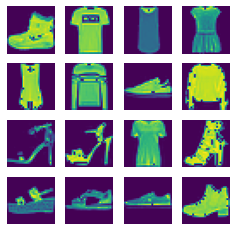

In [6]:
fig = plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_images[i,:,:]+1)
    plt.axis('off')
plt.show()

The value of RGB image is bettween 0 and 255, which not good for deeplearning model, let's normalize the data to [-1, 1].

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Build the model

We will create generator and discriminator in the model.

### Generator

Generator uses `Conv2DTranspose` to upsamping data from random noises to generate images.

The architecture is Dense->LeakyReLU->Conv2DTranspose->LeakyReLU->Conv2DTransepose->LeakyReLU->Conv2DTranspose->tanh

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [13]:
make_generator_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        294912    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

Let's generate a image without training

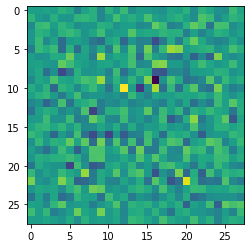

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

### Discriminator

We use CNN model to create a discriminator.   
The architecture is Conv2D->LeakyReLU->Dropout->Conv2D->LeakyReLU->Dropout->Dense

In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))

    return model

In [18]:
make_discriminator_model().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)         

We use discriminator to classify the images true or fake.

In [19]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00239013]], shape=(1, 1), dtype=float32)


## Loss Functions and optimizers

Define loss functions for generator and discriminator

In [20]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Loss function for discriminator


In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Loss function for generator


In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers for generator and discrminator, we use Adam with learning rate 0.0004

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Chectpoints

We use checkpoint to save and restore the model, which is good for training in the long running time task if the training process is interrupted.


In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define trainning step


In [25]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

We use random noise to generate a image,then discriminator classify the real image or fake image.

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Generate and save image


In [28]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training

We use `train()` method to train generator and discriminator. This traning run 50 epochs.


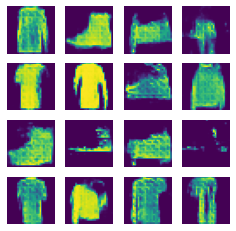

In [29]:
train(train_dataset, EPOCHS)

As we can see above image,the generated image is like the original image. There ara shoes,T-shirts,shirts,and there are also some images we cannot recongnize what it is. However most of images we still can recognize.

Restore

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Result


In [38]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

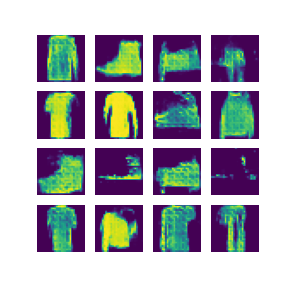

In [39]:
display_image(EPOCHS)

We also can use imageio to create a gif to display the learning process.

In [40]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


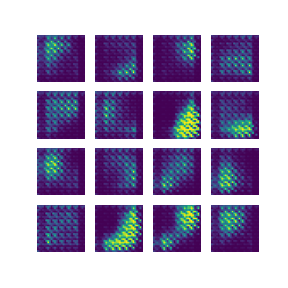

In [43]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Reference


- https://tensorflow.google.cn/tutorials/generative/dcgan
- https://arxiv.org/pdf/1511.06434.pdf
